In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.io import imread,imshow
from glob import glob
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pathlib
import tensorflow as tf
import os
import PIL


from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from math import ceil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

dirs=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        dirs.append(os.path.join(dirname,filename))
        
base_dir='/kaggle/input/skin-cancer-mnist-ham10000'
id_path_dict = {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join(base_dir,'*','*.jpg'))}

2024-05-18 05:52:26.158829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 05:52:26.158945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 05:52:26.326707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
dirs

In [3]:
df = pd.read_csv(dirs[4])
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [4]:
df['age'].fillna(np.mean(df['age']),inplace=True);

/tmp/ipykernel_33/4177480541.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(np.mean(df['age']),inplace=True);


In [5]:
SIZE=118
le = LabelEncoder()
le.fit(df['dx'])

LabelEncoder()

In [6]:
df['label'] = le.transform(df["dx"])

In [7]:
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [8]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


In [9]:
df['label'].value_counts()

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64

In [10]:
df['path'] = df['image_id'].map(id_path_dict.get)
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0,/kaggle/input/skin-cancer-mnist-ham10000/ham10...


In [ ]:
_, ax1 = plt.subplots(2,2,figsize=(15,15))
df['dx'].value_counts().plot(kind='pie', ax=ax1[0,0],autopct='%1.1f%%')
df['sex'].value_counts().plot(kind= 'pie', ax=ax1[0,1],autopct='%1.1f%%')
df['dx_type'].value_counts().plot(kind= 'pie',ax=ax1[1,0],autopct='%1.1f%%')
df['localization'].value_counts().plot(kind= 'pie', ax=ax1[1,1],autopct='%1.1f%%')

In [ ]:
fig , axm = plt.subplots(7,5,figsize=(25,30))
for axn , (type_name,type_row) in zip(axm, df.groupby(['dx'])):
    axn[0].set_title(type_name)
    for axc,(_,crows) in zip(axn,type_row.sample(5).iterrows()):
        axc.imshow(imread(crows['path']))

In [ ]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


plt.tight_layout()
plt.show()

In [46]:
from keras.preprocessing.image import ImageDataGenerator
train_df, temp_df = train_test_split(df, test_size=0.25, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
# datagen = ImageDataGenerator(
#     rotation_range=90,       # Rotate images randomly up to 90 degrees
#     width_shift_range=0.1,   # Shift images horizontally by up to 10%
#     height_shift_range=0.1,  # Shift images vertically by up to 10%
#     zoom_range=0.2,          # Zoom images randomly up to 20%
#     horizontal_flip=True,    # Flip images horizontally randomly
#     vertical_flip=True       # Flip images vertically randomly
# )
# Define ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,       # Rotate images randomly up to 90 degrees
    width_shift_range=0.1,   # Shift images horizontally by up to 10%
    height_shift_range=0.1,  # Shift images vertically by up to 10%
    zoom_range=0.2,          # Zoom images randomly up to 20%
    horizontal_flip=True,    # Flip images horizontally randomly
    vertical_flip=True
)
# size is 224 100
image_height, image_width, batch_size = 100, 100, 264
# Define ImageDataGenerator for test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from DataFrame for training set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',  # Column name containing image paths
    y_col='dx',  # Column name containing labels
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'  # Assuming labels are categorical
)

# Flow from DataFrame for test set
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='dx',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='dx',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7511 validated image filenames belonging to 7 classes.
Found 1252 validated image filenames belonging to 7 classes.
Found 1252 validated image filenames belonging to 7 classes.


**xception_xgb**

In [48]:
import numpy as np
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pickle

# Load the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # Assuming 7 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])



In [49]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1
)

Epoch 1/20
29/29 [==============================] - 252s 8s/step - loss: 39.8621 - accuracy: 0.5909 - val_loss: 1.1617 - val_accuracy: 0.6613
Epoch 2/20
29/29 [==============================] - 234s 8s/step - loss: 1.1404 - accuracy: 0.6706 - val_loss: 1.1442 - val_accuracy: 0.6613
Epoch 3/20
29/29 [==============================] - 232s 8s/step - loss: 1.1387 - accuracy: 0.6705 - val_loss: 1.1492 - val_accuracy: 0.6613
Epoch 4/20
29/29 [==============================] - 220s 8s/step - loss: 1.1295 - accuracy: 0.6706 - val_loss: 1.1368 - val_accuracy: 0.6613
Epoch 5/20
29/29 [==============================] - 230s 8s/step - loss: 1.1125 - accuracy: 0.6706 - val_loss: 1.0828 - val_accuracy: 0.6613
Epoch 6/20
29/29 [==============================] - 234s 8s/step - loss: 1.1199 - accuracy: 0.6673 - val_loss: 1.0945 - val_accuracy: 0.6613
Epoch 7/20
29/29 [==============================] - 221s 8s/step - loss: 1.1292 - accuracy: 0.6705 - val_loss: 1.1526 - val_accuracy: 0.6613
Epoch 8/20
2

In [51]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [53]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Remove the last layer (softmax) from the Xception model to get features
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

# Extract features from the training and validation data
X_train_features = feature_extractor.predict(train_generator)
X_val_features = feature_extractor.predict(valid_generator)

# Get the labels
y_train = train_generator.classes
y_val = valid_generator.classes

# Train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_features, y_train)

# Evaluate the XGBoost model
y_val_pred = xgb_model.predict(X_val_features)
xgb_accuracy = accuracy_score(y_val, y_val_pred)
print(f'XGBoost Validation Accuracy: {xgb_accuracy:.2f}')

5/5 [==============================] - 33s 6s/step
XGBoost Validation Accuracy: 0.66


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Xception Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Xception Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.activations import relu
from xgboost import XGBClassifier

Xception

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.activations import relu
from xgboost import XGBClassifier

# def build_model(input_shape):
#     model = tf.keras.Sequential([
#         Dense(units=512, kernel_initializer=he_uniform(), input_shape=input_shape),
#         BatchNormalization(),
#         Activation(relu),
#         Dropout(0.2),
#         Dense(units=256, kernel_initializer=he_uniform()),
#         BatchNormalization(),
#         Activation(relu),
#         Dropout(0.3),
#         Dense(units=128, kernel_initializer=he_uniform()),
#         BatchNormalization(),
#         Activation(relu),
#         Dropout(0.4),
#         Dense(units=64, kernel_initializer=he_uniform()),
#         BatchNormalization(),
#         Activation(relu),
#         Dropout(0.5),
#         Flatten(),
#         Dense(units=7, kernel_initializer=he_uniform(), activation='softmax')  # Assuming 10 classes
#     ])
#     return model
# def build_model():
#     model = tf.keras.Sequential([
#         Dense(units=512, kernel_initializer=he_uniform(), input_shape=(224, 224, 1)),
#         BatchNormalization(),
#         Activation(relu),
#         Dropout(0.2),
#         Dense(units=256, kernel_initializer=he_uniform()),
#         BatchNormalization(),
#         Activation(relu),
#         Dropout(0.3),
#         Dense(units=128, kernel_initializer=he_uniform()),
#         BatchNormalization(),
#         Activation(relu),
#         Dropout(0.4),
#         Dense(units=64, kernel_initializer=he_uniform()),
#         BatchNormalization(),
#         Activation(relu),
#         Dropout(0.5),
#         Flatten(),
#         Dense(units=7, kernel_initializer=he_uniform(), activation='softmax')  # Assuming 7 classes
#     ])
#     return model
def build_model():
    model = Sequential()
    model.add(Flatten(input_shape=(224, 224, 3)))  # Assuming input shape of images is 150x150x3
    model.add(Dense(64, kernel_initializer=he_uniform()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(32, kernel_initializer=he_uniform()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(16, kernel_initializer=he_uniform()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(7, activation='sigmoid'))
    
    return model
def train_model(model, X_train, y_train, learning_rate=0.1, batch_size=256, epochs=20):
    optimizer = SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history=model.fit(X_train, validation_data = y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    return history
# def train_model(model, train_generator, test_generator, epochs=20):
#     # Compile the model
#     model.compile(loss='categorical_crossentropy',
#               optimizer="adam",
#               metrics=['accuracy'])
    
#     # Train the model using the training generator
#     history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)
    
#     return history

def train_xgboost_model(X_train, y_train, base_score=0.5, learning_rate=0.1, batch_size=256, epochs=20):
    model = XGBClassifier(base_score=base_score, learning_rate=learning_rate)
    model.fit(X_train,validation_data = y_train, eval_metric='logloss', verbose=False)
    return model

# Example usage:
# Assuming you have your data X_train, y_train prepared
# For neural network model
img_height, img_width, channels = 224, 224, 1  # Example dimensions for RGB images
input_shape = (img_height, img_width, channels)
nn_model = build_model()


In [39]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)

In [40]:


# Train XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic', base_score=0.5, learning_rate=0.1)
eval_set = [(x_val, y_val)]
history=xgb_model.fit(x_train, y_train, eval_set=eval_set, eval_metric='error',verbose=True)

# Get predictions from the XGBoost model



/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.08887
[1]	validation_0-error:0.08212
[2]	validation_0-error:0.07898
[3]	validation_0-error:0.07775
[4]	validation_0-error:0.07813
[5]	validation_0-error:0.07765
[6]	validation_0-error:0.07794
[7]	validation_0-error:0.07784
[8]	validation_0-error:0.07841
[9]	validation_0-error:0.07651
[10]	validation_0-error:0.07661
[11]	validation_0-error:0.07575
[12]	validation_0-error:0.07585
[13]	validation_0-error:0.07547
[14]	validation_0-error:0.07566
[15]	validation_0-error:0.07556
[16]	validation_0-error:0.07585
[17]	validation_0-error:0.07604
[18]	validation_0-error:0.07613
[19]	validation_0-error:0.07537
[20]	validation_0-error:0.07499
[21]	validation_0-error:0.07480
[22]	validation_0-error:0.07433
[23]	validation_0-error:0.07452
[24]	validation_0-error:0.07471
[25]	validation_0-error:0.07490
[26]	validation_0-error:0.07490
[27]	validation_0-error:0.07461
[28]	validation_0-error:0.07433
[29]	validation_0-error:0.07433
[30]	validation_0-error:0.07452
[31]	validation_0-

In [35]:
import xgboost as xgb

In [36]:

xgb_model= xgb.Booster().load_model('/kaggle/input/xgb/tensorflow2/xgbb/1/xgb_model.h5')

In [38]:
evals_result = xgb_model.evals_result()
validation_error = evals_result['validation_0']['mlogloss']

# Calculate accuracy from the log loss
accuracy = [1 - error for error in validation_error]

# Plot the accuracy
import matplotlib.pyplot as plt

plt.plot(accuracy)
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

AttributeError: 'NoneType' object has no attribute 'evals_result'

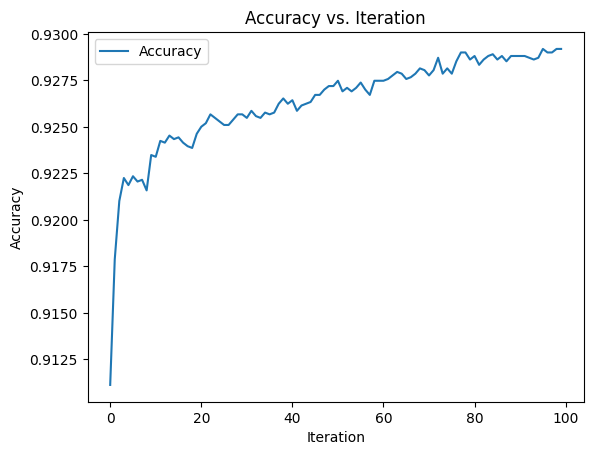

In [41]:
import matplotlib.pyplot as plt

# Extract the validation error from the evaluation history
validation_error = xgb_model.evals_result()['validation_0']['error']

# Calculate accuracy from the error
accuracy = [1 - error for error in validation_error]

# Plot the accuracy
plt.plot(accuracy, label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration')
plt.legend()
plt.show()

In [54]:
plt.savefig('/kaggle/working/xgb.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_auc_score

# Assuming you have your test data X_test and y_test prepared
y_pred_proba = xgb_model.predict_proba(x_test)
y_pred_proba = y_pred_proba[:, 1]  # Assuming binary classification

# Reshape y_pred_proba to 2D array
y_pred_proba = y_pred_proba.reshape(-1, 1)

auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

In [ ]:
xgb_model.save_model('/kaggle/working/xgb_model.h5')

In [ ]:
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Evaluate the XGBoost model
accuracy_xgb = np.mean(y_pred_xgb == y_test_xgb)
print("Accuracy of XGBoost model:", accuracy_xgb)

In [ ]:
history = train_model(nn_model, train_generator, valid_generator)
# output_shape = nn_model.layers[-1].output_shape
# print("Output shape of the last layer:", output_shape)
# For XGBoost model
# xgb_model = train_xgboost_model(X_train, y_train)

In [ ]:
resnet_model = tf.keras.models.load_model('/kaggle/input/resnetmodel/tensorflow2/resnetmodell/2/resnet_model.h5')
# resnet_model.compile(loss='categorical_crossentropy',
#               optimizer="adam",
#               metrics=['accuracy'])
resnet_model.summary()

In [ ]:
resnet_model.evaluate(test_generator)

**CNN**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Define the model
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Flatten
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # Assuming 7 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=valid_generator)

In [ ]:
model.evaluate(test_generator)

In [ ]:
y_pred_proba = resnet_model.predict(test_generator)

# Extract true binary labels from the test generator
# Assuming the test generator yields (X_test, y_test)
y_true = np.concatenate([y for _, y in test_generator], axis=0)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_pred_proba)

print("AUC Score:", auc_score)

In [ ]:
output_shape = resnet_model.layers[-1].output_shape
print("Output shape of the last layer:", output_shape)

**VGG**

In [ ]:
def VGGNet():
    # Input layer
    input_layer = Input(shape=(224, 224, 3))
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Fully connected layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    output_layer = Dense(7, activation='softmax')(x)  # Assuming binary classification
    
    # Create model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [ ]:
vgg_model = VGGNet()

vgg_model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

vgg_model.summary()

In [ ]:
history = vgg_model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_data=test_generator)

In [ ]:
history = resnet_model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=50,
                    validation_data=test_generator)


In [ ]:
vgg_model.evaluate(train_generator)

In [ ]:
vgg_model.evaluate(test_generator)

In [ ]:
resnet_model.evaluate(train_generator)

In [ ]:
resnet_model.evaluate(test_generator)

In [ ]:
# vgg_model.save('/kaggle/working/vgg_model.h5')

In [ ]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Average

# Load the trained individual models
model1 = tf.keras.models.load_model('/kaggle/input/resnetmodel/tensorflow2/resnetmodell/2/resnet_model.h5')
model2 = tf.keras.models.load_model('/kaggle/input/vgg/tensorflow2/vgg16/1/vgg_model.h5')

# Freeze the individual models to prevent further training
# input_layer = model1.input

# # Get the output layers of each model
# output1 = model1.output
# output2 = model2.output

# # Combine the outputs using averaging
# merged_output = Average()([output1, output2])

# # Define the ensemble model with concatenated output as input
# ensemble_model = Model(inputs=input_layer, outputs=merged_output)

# # Compile the ensemble model with appropriate loss and optimizer
# ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the ensemble model with appropriate loss and optimizer
# ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
pred1 = model1.predict(test_generator)
pred2 = model2.predict(test_generator)

# Assuming pred1 and pred2 are arrays of raw predictions
# Apply softmax to get class probabilities
pred1_proba = np.exp(pred1) / np.sum(np.exp(pred1), axis=-1, keepdims=True)
pred2_proba = np.exp(pred2) / np.sum(np.exp(pred2), axis=-1, keepdims=True)

finalpred=(pred1_proba*2+pred2_proba*4)/2

In [ ]:
# y_true = []
# for X_batch, y_batch in test_generator:
#     y_true.extend(y_batch)
finalpred=(pred1_proba*2+pred2_proba*4)/2
# # Convert y_true to a numpy array
# y_true = np.array(y_true)
y_true = test_generator.classes

In [ ]:
final_pred_classes = np.argmax(finalpred, axis=-1)

# Calculate accuracy for the final predictions
accuracy_final = np.mean(final_pred_classes == y_true)
print("Accuracy for Final Predictions:", accuracy_final)

In [ ]:
ensemble_model.summary()

In [ ]:
ensemble_model.evaluate(train_generator)

In [ ]:
ensemble_model.evaluate(test_generator)

In [ ]:
import pickle

# Save the history object to a file
with open('/kaggle/working/vgg_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

**ResNet**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense


In [ ]:
def residual_block(inputs, filters, kernel_size=(3, 3), strides=(1, 1)):
    # Shortcut connection
    shortcut = inputs
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Skip connection
    if strides != (1, 1) or inputs.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides)(shortcut)
    
    # Add shortcut connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [ ]:
def ResNet():
    input_layer = Input(shape=(224, 224, 3))
    
    # Initial convolution layers
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Group 1
    for _ in range(3):
        x = residual_block(x, filters=64)
    
    # Group 2
    x = residual_block(x, filters=128, strides=(2, 2))
    for _ in range(3):
        x = residual_block(x, filters=128)
    
    # Group 3
    x = residual_block(x, filters=256, strides=(2, 2))
    for _ in range(18):
        x = residual_block(x, filters=256)
    
    # Group 4
    x = residual_block(x, filters=512, strides=(2, 2))
    for _ in range(9):
        x = residual_block(x, filters=512)
    
    # Final layers
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    output_layer = Dense(7, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
resnet_model = ResNet()
resnet_model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
# Print model summary
resnet_model.summary()

In [ ]:
history = vgg_model.fit(
    train_generator,
    epochs=50,
    batch_size = 16,
    validation_data=test_generator,
    verbose=2)

In [12]:
from PIL import Image
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [ ]:
# skin_df_balanced.head()

In [13]:
X = np.asarray(df['image'].tolist())
X = X/255.

In [14]:
Y=df['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7)

In [ ]:
# X

In [ ]:
# Y

In [21]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y_cat, test_size=0.1, random_state=42)

# Second split to separate training and validation sets from the remaining data (15% validation, 75% training)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1667, random_state=42)
# The value 0.1667 is approximately 15% of the remaining 90% of the data.

In [ ]:
 x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.20, random_state=42)

In [22]:


# # Set input shape
input_shape = (SIZE, SIZE, 3)
num_classes=7    
# Create model and set the input shape
model = Sequential()
model.add(keras.layers.InputLayer(input_shape))

# Scale the input to [0,1] range
model.add(Rescaling(1/255))
          
# Convolution Layer - Feature maps = 32
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Layer - Feature maps = 64
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution Layer - Feature maps = 128
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

# Softmax Layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Set the compile parameters so that they can be reused for the other models
COMPILE_OPTIMIZED = 'Adam'
COMPILE_LOSS = 'categorical_crossentropy' 
COMPILE_METRICS = ['accuracy']

model.compile(optimizer=COMPILE_OPTIMIZED, 
              loss=COMPILE_LOSS,
              metrics=COMPILE_METRICS)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 118, 118, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 118, 118, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 116, 116, 32)      9248      
                                                                 
 activation_9 (Activation)   (None, 116, 116, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 58, 58, 32)        0         
 g2D)                                                            
                                                      

In [23]:
batch_size = 32 
epochs = 20

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_val, y_val),
    verbose=2)

In [65]:
import pickle

# Save the history object to a file
with open('/kaggle/input/vgg/tensorflow2/vgg16/1/vgg_history.pkl', 'rb') as file:
    # Deserialize and load the object from the file
    history = pickle.load(file)

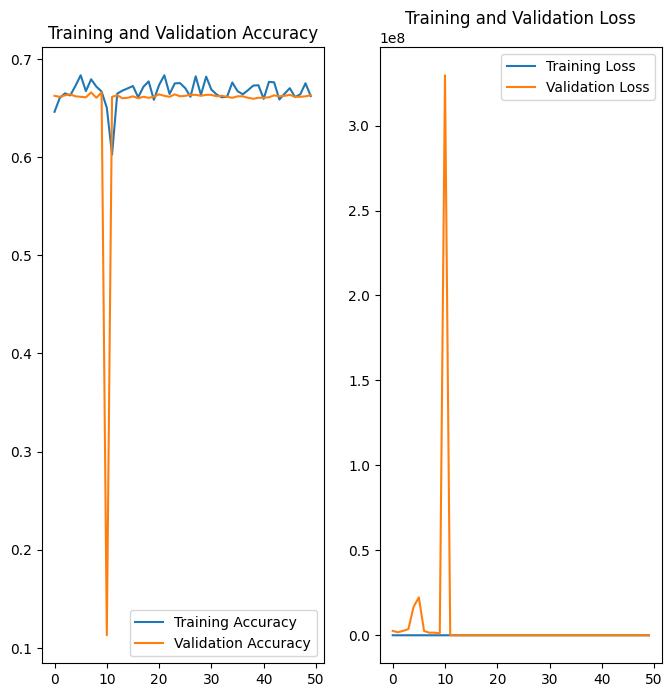

In [66]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('/kaggle/working/vgg.png')
plt.show()

In [ ]:
# num_classes = 7
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
# model = Sequential()
# model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
# #model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))  
# model.add(Dropout(0.3))

# model.add(Conv2D(128, (3, 3),activation='relu'))
# #model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))  
# model.add(Dropout(0.3))

# model.add(Conv2D(64, (3, 3),activation='relu'))
# #model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))  
# model.add(Dropout(0.3))
# model.add(Flatten())

# model.add(Dense(32))
# model.add(Dense(7, activation='softmax'))
# model.summary()

# model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [ ]:
# history = model.fit(
#     x_train, y_train,
#     epochs=epochs,
#     batch_size = batch_size,
#     validation_data=(x_test, y_test),
#     verbose=2)

In [ ]:
# score = model.evaluate(x_test, y_test)
# print('Test accuracy:', score[1] * 100, '%')

In [ ]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


# acc = history.history['acc']
# val_acc = history.history['val_acc']
# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()